# Pool Liquidity Sampling

### **Example of Pool Liquidity**

By defining a probabilistic model, estimate the distribution of an asset in the liquidity pool and identify the equilibrium level that ensures sufficient liquidity without impacting the market price.

1. **Data Generation**
    - Generate data on inflows, outflows, and transaction volumes.
2. **Model Parameter Estimation**
    - Estimate $\lambda_I, \lambda_O, \alpha$ and $\beta$ using historical data.
3. **Simulation**
    - Perform Monte Carlo simulations to generate random samples of inflows, outflows, and transaction volumes.
    - Calculate liquidity supply and demand for each simulation step.
4. **Equilibrium Analysis**
    - Determine the distribution of liquidity levels and identify the equilibrium range.
    - Calculate confidence intervals to quantify uncertainty.
5. **Visualization**
    - Plot the probability distribution of liquidity levels.
    - Highlight the equilibrium range and confidence intervals.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random

In [3]:
# 1. **Data Generation**
historical_inflows = np.random.poisson(lam=10, size=100)
historical_outflows = np.random.poisson(lam=8, size=100)
historical_volumes = np.random.gamma(shape=2.0, scale=2.0, size=100)


In [4]:
# 2. **Model Parameter Estimation**
def model(inflows=None, outflows=None, volumes=None):
    lambda_I = numpyro.sample('lambda_I', dist.Exponential(1.0))
    lambda_O = numpyro.sample('lambda_O', dist.Exponential(1.0))
    alpha = numpyro.sample('alpha', dist.Gamma(2.0, 1.0))
    beta = numpyro.sample('beta', dist.Gamma(2.0, 1.0))

    with numpyro.plate('data', len(inflows) if inflows is not None else 1):
        if inflows is not None:
            numpyro.sample('obs_inflows', dist.Poisson(lambda_I), obs=inflows)
        if outflows is not None:
            numpyro.sample('obs_outflows', dist.Poisson(lambda_O), obs=outflows)
        if volumes is not None:
            numpyro.sample('obs_volumes', dist.Gamma(alpha, beta), obs=volumes)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(0), inflows=historical_inflows, outflows=historical_outflows, volumes=historical_volumes)
samples = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [00:01<00:00, 1810.22it/s, 7 steps of size 3.99e-01. acc. prob=0.93] 


In [6]:
# 3. **Simulation**
num_simulations = 1000

# Use the estimated parameters to generate new samples
def simulate():
    lambda_I = numpyro.sample('lambda_I', dist.Exponential(1.0))
    lambda_O = numpyro.sample('lambda_O', dist.Exponential(1.0))
    alpha = numpyro.sample('alpha', dist.Gamma(2.0, 1.0))
    beta = numpyro.sample('beta', dist.Gamma(2.0, 1.0))

    inflows = numpyro.sample('inflows', dist.Poisson(lambda_I))
    outflows = numpyro.sample('outflows', dist.Poisson(lambda_O))
    volumes = numpyro.sample('volumes', dist.Gamma(alpha, beta))

    return inflows, outflows, volumes

predictive = Predictive(simulate, posterior_samples=samples, num_samples=num_simulations)
simulated_data = predictive(random.PRNGKey(1))

simulated_inflows = simulated_data['inflows']
simulated_outflows = simulated_data['outflows']
simulated_volumes = simulated_data['volumes']

# Calculate liquidity supply and demand for each simulation step
liquidity_supply = simulated_inflows
liquidity_demand = simulated_outflows

/var/folders/04/kxzm_nrn6w9fwt4f_qnyr1m00000gn/T/ipykernel_5796/3789121203.py:17: UserWarning: Sample's batch dimension size 2000 is different from the provided 1000 num_samples argument. Defaulting to 2000.
  predictive = Predictive(simulate, posterior_samples=samples, num_samples=num_simulations)


In [33]:
# 4. **Equilibrium Analysis**
import numpy as np
import scipy.stats

def standard_deviation_rule(data, level=95):
    percentiles = {
        68: [16, 84],
        95: [2.5, 97.5],
        99.7:[0.15, 99.85]
    }
    percentiles = percentiles[level]
    output_range = (np.percentile(data, percentiles[0]), np.percentile(data, percentiles[1]))
    return  output_range

equilibrium_levels = liquidity_supply - liquidity_demand
yellow, green, purple = np.array([68, 95, 99.7])
yellow_range = standard_deviation_rule(equilibrium_levels, level = yellow)
green_range = standard_deviation_rule(equilibrium_levels, level = green)
purple_range = standard_deviation_rule(equilibrium_levels, level = purple)


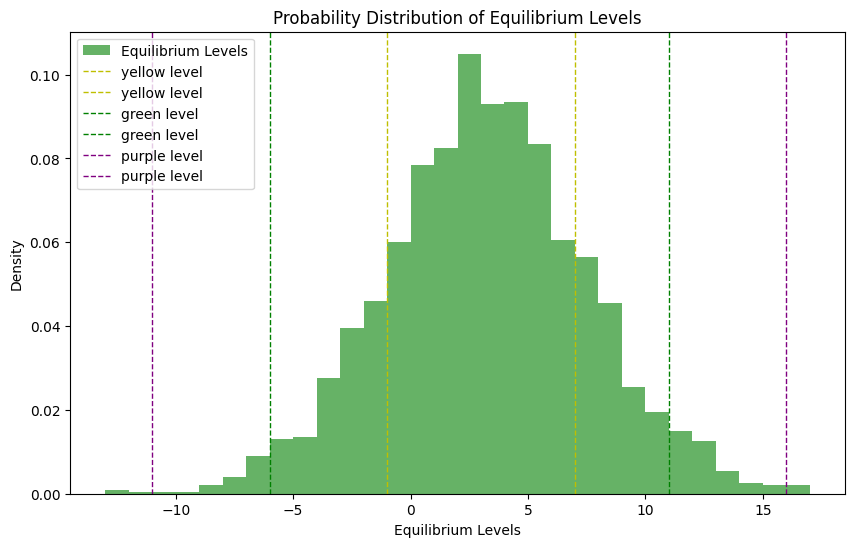

In [35]:
# 5. **Visualization**
plt.figure(figsize=(10, 6))
plt.hist(equilibrium_levels, bins=30, density=True, alpha=0.6, color='g', label='Equilibrium Levels')
plt.axvline(yellow_range[0], color='y', linestyle='dashed', linewidth=1, label='yellow level')
plt.axvline(yellow_range[1], color='y', linestyle='dashed', linewidth=1, label='yellow level')

plt.axvline(green_range[0], color='g', linestyle='dashed', linewidth=1, label='green level')
plt.axvline(green_range[1], color='g', linestyle='dashed', linewidth=1, label='green level')

plt.axvline(purple_range[0], color='purple', linestyle='dashed', linewidth=1, label='purple level')
plt.axvline(purple_range[1], color='purple', linestyle='dashed', linewidth=1, label='purple level')

plt.xlabel('Equilibrium Levels')
plt.ylabel('Density')
plt.title('Probability Distribution of Equilibrium Levels')
plt.legend()
plt.show()